# Temps 2 : Stocker les données avec Elastic Search

## 1. Mise en place 

docker run -d --name elastic -p 9200:9200 -v /home/apprenant/DevIA/psy_nlp/elasticsearch:/usr/share/elasticsearch/data -e "discovery.type=single-node" docker.elastic.co/elasticsearch/elasticsearch:7.17.10

## 2. Mapper et importer les données

In [110]:
import pandas as pd 

df = pd.read_csv('Emotion_final.csv')

### Importer le modèle

In [111]:
import pickle

# Charger le modèle TF-IDF entraîné
with open('model_bow.pkl', 'rb') as f:
    model_bow = pickle.load(f)

/home/apprenant/miniconda3/envs/nlp-env/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Préparer le préprocessing des données

In [117]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import FreqDist
import string

# Télécharger les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Prétraitement du corpus de texte
all_text_corpus = ' '.join(df['Text'])
tokens = word_tokenize(all_text_corpus)

# Conversion en minuscules et suppression de la ponctuation
tokens = [token.lower() for token in tokens if token not in string.punctuation]

# Lemmatization
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(token) for token in tokens]

# Filtrage des stopwords
stopwords_list = stopwords.words('english')
tokens = [token for token in tokens if token not in stopwords_list]

word_freq = FreqDist(tokens)

# Sélectionner les mots à exclure qui apparaissent plus de 100 fois dans le corpus
common_words_to_exclude = [word for word, count in word_freq.items() if count > 100]


# Étape de prétraitement : tokenization, gestion de la ponctuation, des émojis, des stopwords, lemmatisation et streaming

def preprocess_text(text):
    # Tokenization : divise le texte en unités linguistiques
    tokens = word_tokenize(text)
    
    # Gestion de la ponctuation et des émojis
    tokens = [token for token in tokens if token.isalnum()]
    
    # Gestion des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # tokens = [word for word in tokens if word.lower() not in common_words_to_exclude]
    
    # Streaming pour marquer les négations (ex : "not happy" -> "not_happy")
    tokens = mark_negation(tokens)
    
    # Rejoindre les tokens en une chaîne de texte
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


[nltk_data] Downloading package punkt to /home/apprenant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Préparer la liste des patients

In [118]:
from faker import Faker 

fake = Faker()
patients_list = [
    (fake.last_name(),fake.first_name()) for _ in range (200)
]

patients_list

[('Norton', 'Joseph'),
 ('Schroeder', 'Stephen'),
 ('Walsh', 'Brian'),
 ('Lee', 'Jon'),
 ('Oneill', 'Nicole'),
 ('Allen', 'James'),
 ('Davis', 'Mark'),
 ('Scott', 'Barbara'),
 ('Walker', 'Jason'),
 ('Fisher', 'Elizabeth'),
 ('Knox', 'Michael'),
 ('Anderson', 'Daniel'),
 ('Martinez', 'Shannon'),
 ('White', 'Jill'),
 ('Maldonado', 'Stacy'),
 ('Baker', 'Margaret'),
 ('Diaz', 'Phillip'),
 ('Williams', 'Matthew'),
 ('Weaver', 'Gregory'),
 ('Sullivan', 'Timothy'),
 ('Jackson', 'Teresa'),
 ('Davis', 'Jill'),
 ('Marshall', 'Christopher'),
 ('Peterson', 'Alyssa'),
 ('Black', 'Amber'),
 ('Miller', 'Mark'),
 ('Snow', 'Cindy'),
 ('Simmons', 'Robert'),
 ('Camacho', 'Elizabeth'),
 ('White', 'Laura'),
 ('Roy', 'Christopher'),
 ('Mullen', 'Christina'),
 ('Bridges', 'Alexis'),
 ('Green', 'Amanda'),
 ('Hudson', 'Susan'),
 ('Allen', 'Colton'),
 ('Taylor', 'Haley'),
 ('Graham', 'Lee'),
 ('Johnson', 'William'),
 ('Mitchell', 'Michael'),
 ('Taylor', 'Jason'),
 ('Figueroa', 'Claire'),
 ('Smith', 'Shawn'),
 (

### Mapper et importer les données

In [120]:
from elasticsearch import Elasticsearch
from faker import Faker
import random

# Créer une instance du client Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme':'http'}])

# Définir le mapping pour l'index "notes"
mapping = {
  "properties": {
    "patient_lastname": {
      "type": "keyword"
    },
    "patient_firstname": {
      "type": "keyword"
    },
    "text": {
      "type": "text",
      "analyzer": "standard",
    },
    "date": {
      "type": "date"
    },
    "patient_left": {
      "type": "boolean"
    },
    "emotion": {
      "type": "keyword"
    },
    "confidence": {
      "type": "float"
    }
  }
}

# Créer l'index "notes" avec le mapping
es.indices.create(index='notes', body={"mappings": mapping})

# Prétraitement du corpus de texte
preprocessed_text = df['Text'].apply(preprocess_text)

# Création du modèle Bag of Words
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(preprocessed_text)

# Générer les données fictives avec Faker et les insérer dans l'index "notes"
fake = Faker()
for index,row in df.iterrows():
  # Obtenir la représentation vectorielle de la ligne actuelle
  row_vector = bow_features[index]
    
  # Prédire l'émotion pour la représentation vectorielle de la ligne actuelle
  emotion = model_bow.predict(row_vector)[0]  # Utilisation de [0] pour obtenir la prédiction unique
  
  # Obtenir le score de précision du modèle pour la représentation vectorielle de la ligne actuelle
  confidence = model_bow.predict_proba(row_vector).max()
  
  patient = random.choice(patients_list)
  
  doc = {
        "patient_lastname": patient[0],
        "patient_firstname": patient[1],
        "text": row['Text'],
        "date": fake.date_this_decade(),
        "patient_left": random.choice([True, False]),
        "emotion": emotion,
        "confidence": confidence
    }
  es.index(index='notes', body=doc)

# Rafraîchir l'index pour rendre les données disponibles pour la recherche
es.indices.refresh(index='notes')


/tmp/ipykernel_70008/2549419073.py:37: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index='notes', body={"mappings": mapping})
/tmp/ipykernel_70008/2549419073.py:37: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.create(index='notes', body={"mappings": mapping})
/tmp/ipykernel_70008/2549419073.py:69: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.index(index='notes', body=doc)
/tmp/ipykernel_70008/2549419073.py:69: ElasticsearchWarning: Elasticsearch built-in security features are not enab

ObjectApiResponse({'_shards': {'total': 2, 'successful': 1, 'failed': 0}})

### Aperçu des documents de l'index

In [134]:
from elasticsearch import Elasticsearch

# Créer une instance du client Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Effectuer une recherche sur l'index "notes"
search_results = es.search(index='notes', size=10)  # Récupérer les 10 premiers documents

# Parcourir les résultats de la recherche
for hit in search_results['hits']['hits']:
    # Récupérer le document
    document = hit['_source']
    
    # Afficher les informations du document
    print("Patient: {} {}".format(document['patient_firstname'], document['patient_lastname']))
    print("Date: {}".format(document['date']))
    print("Text: {}".format(document['text']))
    print("Emotion: {}".format(document['emotion']))
    print("Confidence: {}".format(document['confidence']))
    print("-----")


Patient: Joseph Ortega
Date: 2021-12-21
Text: i was feeling fabulous until friday morning when i started to get these awful cramps at work
Emotion: happy
Confidence: 0.6982905249503254
-----
Patient: Mark Miller
Date: 2020-02-04
Text: i feel honoured to have been able to call them friends to share their brotherhood
Emotion: happy
Confidence: 0.9348020541564365
-----
Patient: Christopher Flynn
Date: 2022-02-04
Text: i had begun to feel apprehensive when thick black rain clouds stormed into the sky above town
Emotion: fear
Confidence: 0.9376474503437976
-----
Patient: Michael Knox
Date: 2021-08-12
Text: i had stated to her the reason i feel so fearful is because i feel unsafe
Emotion: fear
Confidence: 0.8626518482628259
-----
Patient: Julie Foster
Date: 2022-07-30
Text: i didn t feel like getting shaken down by the tsa quite yet so i pulled off to the side at creative croissants for a lunch
Emotion: fear
Confidence: 0.8130373085503506
-----
Patient: Allison Hunter
Date: 2020-05-01
Text: 

/tmp/ipykernel_70008/2862898211.py:7: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  search_results = es.search(index='notes', size=10)  # Récupérer les 10 premiers documents


### Cellule pour supprimer l'index

In [119]:
from elasticsearch import Elasticsearch

# Se connecter à Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme':'http'}])

# Supprimer l'index "notes"
es.indices.delete(index='notes', ignore=[400, 404])

print("Index 'notes' supprimé avec succès.")


Index 'notes' supprimé avec succès.


/tmp/ipykernel_70008/95890536.py:7: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  es.indices.delete(index='notes', ignore=[400, 404])
/tmp/ipykernel_70008/95890536.py:7: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.delete(index='notes', ignore=[400, 404])


## 3. Requêtes

### Exemple de requête 

In [135]:
from elasticsearch import Elasticsearch

# Créez une instance de connexion Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme':'http'}])

# Exemple de requête de recherche
query = {
  "query": {
    "bool": {
      "must": [
        {"match": {"patient_lastname": "Ortega"}},
        {"match": {"patient_firstname": "Joseph"}}
      ]
    }
  }
}

# Envoyer la requête de recherche à Elasticsearch
response = es.search(index='notes', body=query)

# Traiter la réponse renvoyée par Elasticsearch
for hit in response['hits']['hits']:
    print(hit['_source'])

{'patient_lastname': 'Ortega', 'patient_firstname': 'Joseph', 'text': 'i was feeling fabulous until friday morning when i started to get these awful cramps at work', 'date': '2021-12-21', 'patient_left': True, 'emotion': 'happy', 'confidence': 0.6982905249503254}
{'patient_lastname': 'Ortega', 'patient_firstname': 'Joseph', 'text': 'i feel lonely and lost', 'date': '2020-10-04', 'patient_left': False, 'emotion': 'sadness', 'confidence': 0.9751561634976588}
{'patient_lastname': 'Ortega', 'patient_firstname': 'Joseph', 'text': 'i have been highly critical of dennis covingtons book in this article i must admit that he did say something that has merit in this discussion when he noted in his closing chapters this feeling after god is a dangerous business', 'date': '2021-09-05', 'patient_left': True, 'emotion': 'anger', 'confidence': 0.9704965096025518}
{'patient_lastname': 'Ortega', 'patient_firstname': 'Joseph', 'text': 'i thought i would very sweetly cover over what i was really feeling a

/tmp/ipykernel_70008/146903857.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query)
/tmp/ipykernel_70008/146903857.py:19: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index='notes', body=query)


### 1 - En recherchant dans la base elastic search, aboutissez à un data frame permettant d’afficher la répartition des sentiments des textes pour un patient (nom/prénom)


In [124]:
from elasticsearch import Elasticsearch
import pandas as pd

# Créez une instance de connexion Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme':'http'}])

# Exemple de requête de recherche pour la répartition des émotions par patient
query = {
  "size": 0,
  "aggs": {
    "patients": {
      "terms": {
        "field": "patient_lastname",  # Champ de regroupement par nom de famille du patient
        "size": 300  # Nombre maximum de patients à récupérer (modifier selon vos besoins)
      },
      "aggs": {
        "patient_firstnames": {
          "terms": {
            "field": "patient_firstname",  # Champ de regroupement par prénom du patient
            "size": 300  # Nombre maximum de prénoms à récupérer par patient (modifier selon vos besoins)
          },
          "aggs": {
            "emotions": {
              "terms": {
                "field": "emotion",  # Champ de regroupement par émotion
                "size": 10  # Nombre maximum d'émotions à récupérer par patient (modifier selon vos besoins)
              }
            }
          }
        }
      }
    }
  }
}

# Envoyer la requête de recherche à Elasticsearch
response = es.search(index='notes', body=query)

# Liste pour stocker les données des patients et des émotions
patient_data = []

# Traiter la réponse renvoyée par Elasticsearch
for patient_bucket in response['aggregations']['patients']['buckets']:
    patient_lastname = patient_bucket['key']
    for firstname_bucket in patient_bucket['patient_firstnames']['buckets']:
        patient_firstname = firstname_bucket['key']
        emotions = {emotion_bucket['key']: emotion_bucket['doc_count']
                    for emotion_bucket in firstname_bucket['emotions']['buckets']}
        patient_entry = {'Patient': patient_lastname + ' ' + patient_firstname}
        patient_entry.update(emotions)
        patient_data.append(patient_entry)

# Créer un DataFrame à partir des données des patients
df = pd.DataFrame(patient_data)

# Remplacer les valeurs NaN par 0 pour les émotions sans occurrence
df = df.fillna(0)

# Afficher le DataFrame
display(df)





/tmp/ipykernel_70008/439470295.py:37: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query)
/tmp/ipykernel_70008/439470295.py:37: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index='notes', body=query)


,Patient,happy,sadness,fear,anger,love,surprise
0,Green Amanda,43,38,17,15,9,3.0
1,Green Dustin,38,37,21,10,9,4.0
2,Green Stephanie,36,34,9,23,10,4.0
3,Green Katrina,32,33,10,22,5,5.0
4,Green Laura,41,29,19,8,7,2.0
...,...,...,...,...,...,...,...
195,Braun Eric,30,23,10,13,8,5.0
196,Miles Kevin,33,14,8,16,9,8.0
197,Kline Jaime,33,22,11,8,8,5.0
198,Deleon Ricky,22,23,13,16,8,3.0


### 2- Élaborez une matrice de sentiments contradictoire (toujours en utilisant la base elastic search)
On veut savoir parmi les documents classifiés comme happy, quel pourcentage contient le mot “sadness”. Puis quel pourcentage contient “fear” …
Et cela pour tous les sentiment.
On représente les résultats dans une HeatMap


In [125]:
from elasticsearch import Elasticsearch

# Créez une instance de connexion Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Liste des sentiments à analyser avec leurs mots associés
sentiments = {
    'happy': ['sadness', 'fear', 'anger', 'surprise', 'love'],
    'sadness': ['happy', 'fear', 'anger', 'surprise', 'love'],
    'fear': ['sadness', 'happy', 'anger', 'surprise', 'love'],
    'anger': ['sadness', 'happy', 'fear', 'surprise', 'love'],
    'love': ['sadness', 'happy', 'fear', 'anger', 'surprise'],
    'surprise': ['sadness', 'happy', 'fear', 'anger', 'love']
}

# Dictionnaire pour stocker les résultats
sentiment_results = {}

# Parcourir les sentiments et les mots associés
for sentiment, words in sentiments.items():
    # Dictionnaire pour stocker les pourcentages du sentiment actuel
    percentages = {}
    
    # Exécuter une requête pour récupérer les documents du sentiment actuel
    query = {
        "query": {
            "match": {
                "emotion": sentiment
            }
        }
    }
    response = es.search(index='notes', body=query, size=1000)
    total_sentiment_docs = response['hits']['total']['value']
    
    # Parcourir les mots associés au sentiment actuel
    for word in words:
        # Exécuter une requête pour récupérer les documents du sentiment actuel contenant le mot
        query = {
            "query": {
                "bool": {
                    "must": [
                        {
                            "match": {
                                "emotion": sentiment
                            }
                        },
                        {
                            "match": {
                                "text": word
                            }
                        }
                    ]
                }
            }
        }
        response = es.search(index='notes', body=query, size=1000)
        docs_with_word = response['hits']['total']['value']
        
        # Calculer le pourcentage
        percentage = (docs_with_word / total_sentiment_docs) * 100
        percentages[word] = percentage
    
    sentiment_results[sentiment] = percentages

# Afficher les résultats
for sentiment, percentages in sentiment_results.items():
    print(f"Pour le sentiment '{sentiment}':")
    for word, percentage in percentages.items():
        print(f"Pourcentage de documents contenant le mot '{word}': {percentage:.2f}%")
    print()


/tmp/ipykernel_70008/1816879509.py:32: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query, size=1000)
/tmp/ipykernel_70008/1816879509.py:32: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index='notes', body=query, size=1000)
/tmp/ipykernel_70008/1816879509.py:56: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query, size=1000)
/tmp/ipykernel_70008/1816879509.py:56: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible t

Pour le sentiment 'happy':
Pourcentage de documents contenant le mot 'sadness': 0.08%
Pourcentage de documents contenant le mot 'fear': 0.20%
Pourcentage de documents contenant le mot 'anger': 0.14%
Pourcentage de documents contenant le mot 'surprise': 0.04%
Pourcentage de documents contenant le mot 'love': 2.98%

Pour le sentiment 'sadness':
Pourcentage de documents contenant le mot 'happy': 1.12%
Pourcentage de documents contenant le mot 'fear': 0.25%
Pourcentage de documents contenant le mot 'anger': 0.17%
Pourcentage de documents contenant le mot 'surprise': 0.11%
Pourcentage de documents contenant le mot 'love': 1.94%

Pour le sentiment 'fear':
Pourcentage de documents contenant le mot 'sadness': 0.11%
Pourcentage de documents contenant le mot 'happy': 0.42%
Pourcentage de documents contenant le mot 'anger': 0.23%
Pourcentage de documents contenant le mot 'surprise': 0.11%
Pourcentage de documents contenant le mot 'love': 1.74%

Pour le sentiment 'anger':
Pourcentage de documents 

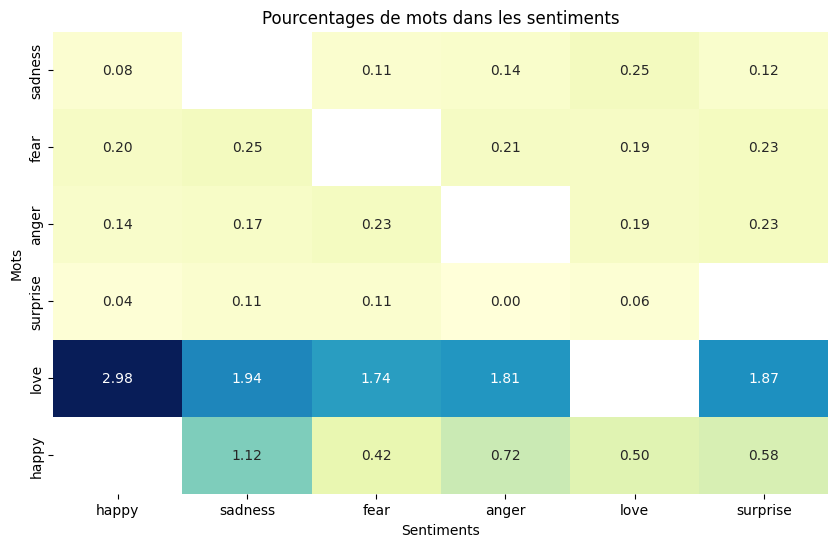

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir les résultats en un DataFrame
df = pd.DataFrame.from_dict(sentiment_results)

# Générer une heatmap à partir du DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
plt.title("Pourcentages de mots dans les sentiments")
plt.xlabel("Sentiments")
plt.ylabel("Mots")
plt.show()


### 3- Pour chacune des étapes du deuil (denial, anger, bargaining, depression, and acceptance) rechercher le nombre de text correspondants à l’aide: d’une recherche pleine puis d’une fuzzy recherche.


In [127]:
from elasticsearch import Elasticsearch

# Créer une instance de connexion Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Étapes du deuil
stages = ["denial", "anger", "bargaining", "depression", "acceptance"]

# Recherche pleine (exacte)
exact_results = {}
for stage in stages:
    query = {
        "query": {
            "match": {
                "text": stage
            }
        }
    }
    response = es.search(index='notes', body=query)
    total_hits = response['hits']['total']['value']
    exact_results[stage] = total_hits

# Recherche floue (fuzzy)
fuzzy_results = {}
for stage in stages:
    query = {
        "query": {
            "fuzzy": {
                "text": {
                    "value": stage,
                    "fuzziness": "AUTO"
                }
            }
        },
        
    }
    response = es.search(index='notes', body=query)
    total_hits = response['hits']['total']['value']
    fuzzy_results[stage] = total_hits

# Afficher les résultats
for stage in stages:
    print("Étape du deuil: {}".format(stage))
    print("Recherche pleine (exacte): {} textes correspondants".format(exact_results[stage]))
    print("Recherche floue (fuzzy): {} textes correspondants".format(fuzzy_results[stage]))
    print()


/tmp/ipykernel_70008/3806219522.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query)
/tmp/ipykernel_70008/3806219522.py:19: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index='notes', body=query)


Étape du deuil: denial
Recherche pleine (exacte): 2 textes correspondants
Recherche floue (fuzzy): 119 textes correspondants

Étape du deuil: anger
Recherche pleine (exacte): 66 textes correspondants
Recherche floue (fuzzy): 82 textes correspondants

Étape du deuil: bargaining
Recherche pleine (exacte): 0 textes correspondants
Recherche floue (fuzzy): 0 textes correspondants

Étape du deuil: depression
Recherche pleine (exacte): 23 textes correspondants
Recherche floue (fuzzy): 84 textes correspondants

Étape du deuil: acceptance
Recherche pleine (exacte): 9 textes correspondants
Recherche floue (fuzzy): 71 textes correspondants



/tmp/ipykernel_70008/3806219522.py:37: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query)
/tmp/ipykernel_70008/3806219522.py:37: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index='notes', body=query)


#### Regroupement des textes par émotion

In [128]:
from elasticsearch import Elasticsearch

# Créer une instance de connexion Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Étapes du deuil
stages = ["denial", "anger", "bargaining", "depression", "acceptance"]

# Recherche pleine (exacte)
exact_results = {}
for stage in stages:
    query = {
        "query": {
            "match": {
                "text": stage
            }
        },
        "size": 0,
        "aggs": {
            "emotions": {
                "terms": {
                    "field": "emotion",
                    "size": 10
                }
            }
        }
    }
    response = es.search(index='notes', body=query)
    total_hits = response['hits']['total']['value']
    exact_results[stage] = total_hits

    # Répartition des textes par émotion
    emotion_buckets = response['aggregations']['emotions']['buckets']
    emotion_distribution = {bucket['key']: bucket['doc_count'] for bucket in emotion_buckets}

    # Afficher les résultats
    print("Étape du deuil: {}".format(stage))
    print("Recherche pleine (exacte): {} textes correspondants".format(total_hits))
    print()
    print("Répartition des textes par émotion:")
    for emotion, count in emotion_distribution.items():
        print("- {} : {} ({}%)".format(emotion, count, (count / total_hits) * 100))
    print()

# Recherche floue (fuzzy)
fuzzy_results = {}
for stage in stages:
    query = {
        "query": {
            "fuzzy": {
                "text": {
                    "value": stage,
                    "fuzziness": "AUTO"
                }
            }
        },
        "size": 0,
        "aggs": {
            "emotions": {
                "terms": {
                    "field": "emotion",
                    "size": 10
                }
            }
        }
    }
    response = es.search(index='notes', body=query)
    total_hits = response['hits']['total']['value']
    fuzzy_results[stage] = total_hits

    # Répartition des textes par émotion
    emotion_buckets = response['aggregations']['emotions']['buckets']
    emotion_distribution = {bucket['key']: bucket['doc_count'] for bucket in emotion_buckets}

    # Afficher les résultats
    print("Étape du deuil: {}".format(stage))
    print("Recherche floue (fuzzy): {} textes correspondants".format(total_hits))
    print()
    print("Répartition des textes par émotion:")
    for emotion, count in emotion_distribution.items():
        print("- {} : {} ({}%)".format(emotion, count, (count / total_hits) * 100))
    print()


/tmp/ipykernel_70008/39863912.py:28: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query)
/tmp/ipykernel_70008/39863912.py:28: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index='notes', body=query)


Étape du deuil: denial
Recherche pleine (exacte): 2 textes correspondants

Répartition des textes par émotion:
- fear : 1 (50.0%)
- sadness : 1 (50.0%)

Étape du deuil: anger
Recherche pleine (exacte): 66 textes correspondants

Répartition des textes par émotion:
- anger : 34 (51.515151515151516%)
- sadness : 11 (16.666666666666664%)
- happy : 10 (15.151515151515152%)
- fear : 6 (9.090909090909092%)
- love : 3 (4.545454545454546%)
- surprise : 2 (3.0303030303030303%)

Étape du deuil: bargaining
Recherche pleine (exacte): 0 textes correspondants

Répartition des textes par émotion:

Étape du deuil: depression
Recherche pleine (exacte): 23 textes correspondants

Répartition des textes par émotion:
- sadness : 15 (65.21739130434783%)
- happy : 5 (21.73913043478261%)
- anger : 1 (4.3478260869565215%)
- fear : 1 (4.3478260869565215%)
- surprise : 1 (4.3478260869565215%)

Étape du deuil: acceptance
Recherche pleine (exacte): 9 textes correspondants

Répartition des textes par émotion:
- happ

/tmp/ipykernel_70008/39863912.py:67: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query)
/tmp/ipykernel_70008/39863912.py:67: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index='notes', body=query)


Étape du deuil: acceptance
Recherche floue (fuzzy): 71 textes correspondants

Répartition des textes par émotion:
- happy : 63 (88.73239436619718%)
- sadness : 4 (5.633802816901409%)
- love : 3 (4.225352112676056%)
- anger : 1 (1.4084507042253522%)



### 4- Rechercher les textes:
qui doivent matcher l’expression “good day” (must)
chez les patients encore en consultation (filter)
qui contiennent si possible “to rest” (should)
qui ne doivent pas avoir seuil de confiance inférieur à 0.5 s’il existe. 
Observer la répartition de ces résultats par sentiment


In [129]:
from elasticsearch import Elasticsearch

# Créer une instance de connexion Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Requête Elasticsearch
query = {
    "query": {
        "bool": {
            "must": {
                "match": {
                    "text": "good day"
                }
            },
            "filter": {
                "term": {
                    "patient_left": False
                }
            },
            "should": {
                "match": {
                    "text": "to rest"
                }
            },
            "must_not": {
                "range": {
                    "confidence": {
                        "lt": 0.5
                    }
                }
            }
        }
    },
    "size": 0,
    "aggs": {
        "emotions": {
            "terms": {
                "field": "emotion",
            }
        }
    }
}

# Envoyer la requête de recherche à Elasticsearch
response = es.search(index='notes', body=query)

# Nombre total de textes correspondants
total_texts = response['hits']['total']['value']

# Répartition des textes par émotion
emotion_buckets = response['aggregations']['emotions']['buckets']
emotion_distribution = {bucket['key']: bucket['doc_count'] for bucket in emotion_buckets}

# Afficher les résultats
print("Nombre total de textes correspondants :", total_texts)
print("Répartition des textes par émotion:")
for emotion, count in emotion_distribution.items():
    print("- {} : {} ({}%)".format(emotion, count, (count / total_texts) * 100))


Nombre total de textes correspondants : 464
Répartition des textes par émotion:
- happy : 211 (45.474137931034484%)
- sadness : 126 (27.155172413793103%)
- anger : 46 (9.913793103448276%)
- fear : 43 (9.267241379310345%)
- love : 27 (5.818965517241379%)
- surprise : 11 (2.3706896551724137%)


/tmp/ipykernel_70008/2709644749.py:45: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index='notes', body=query)
/tmp/ipykernel_70008/2709644749.py:45: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index='notes', body=query)


## 4. Questions théoriques

### Qu'est-ce que le sharding, comment pourrait-on imaginer un sharding sur cet index ? 

Le sharding permet de découper un index en plusieurs morceaux pour permettre les requêtes en parallèle. C'est utile pour les gros index (>50Gb).

In [130]:
from elasticsearch import Elasticsearch

# Créer une instance de connexion Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Nom de l'index
index_name = "notes"

# Récupérer les informations sur l'index
response = es.cat.indices(index=index_name, bytes="b", format="json")

# Extraire la taille de l'index
index_size_in_bytes = response[0]['store.size']
index_size = int(index_size_in_bytes) / 1024 / 1024  # Convertir en mégaoctets

# Afficher la taille de l'index
print("Taille de l'index '{}': {} Mo".format(index_name, index_size))



Taille de l'index 'notes': 4.577142715454102 Mo


/tmp/ipykernel_70008/2158034974.py:10: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.cat.indices(index=index_name, bytes="b", format="json")


In [56]:
from elasticsearch import Elasticsearch

# Créer une instance de connexion Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Nom de l'index
index_name = "notes"

# Récupérer les statistiques de l'index
response = es.cat.count(index=index_name, format="json")

# Extraire le nombre de documents
doc_count = int(response[0]['count'])

# Afficher le nombre de documents
print("Nombre de documents dans l'index '{}': {}".format(index_name, doc_count))


Nombre de documents dans l'index 'notes': 21459


/tmp/ipykernel_70008/144231009.py:10: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.cat.count(index=index_name, format="json")


In [133]:
from elasticsearch import Elasticsearch

# Créez une instance du client Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Index source (ancien index)
source_index = 'notes'

# Index de destination (nouvel index avec sharding)
destination_index = 'notes_new'

# Requête pour récupérer tous les documents de l'ancien index
query = {
    "query": {
        "match_all": {}
    },
    "size": 5000  # Définissez la taille en fonction du nombre total de documents dans l'ancien index
}

# Effectuez la requête de recherche sur l'ancien index
response = es.search(index=source_index, body=query, scroll='1m')

# Vérifiez si la recherche a renvoyé des résultats
if 'hits' in response and 'hits' in response['hits']:
    # Itérez sur les résultats et indexez les documents dans le nouvel index
    while len(response['hits']['hits']) > 0:
        # Récupérez les résultats actuels
        hits = response['hits']['hits']
        
        # Indexez chaque document dans le nouvel index
        for hit in hits:
            doc = hit['_source']
            es.index(index=destination_index, body=doc)
        
        # Effectuez un défilement pour récupérer la page suivante des résultats
        scroll_id = response['_scroll_id']
        response = es.scroll(scroll_id=scroll_id, scroll='1m')

        # Vérifiez si la recherche suivante a renvoyé des résultats
        if 'hits' not in response or 'hits' not in response['hits']:
            break
else:
    print('Aucun résultat trouvé lors de la recherche sur l\'ancien index.')

# Rafraîchissez l'index nouvellement chargé pour rendre les données disponibles pour la recherche
es.indices.refresh(index=destination_index)


/tmp/ipykernel_70008/1527358209.py:21: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index=source_index, body=query, scroll='1m')
/tmp/ipykernel_70008/1527358209.py:21: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index=source_index, body=query, scroll='1m')
/tmp/ipykernel_70008/1527358209.py:33: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.index(index=destination_index, body=doc)
/tmp/ipykernel_70008/1527358209.py:33: ElasticsearchWarning: Elasticsearch built-in security f

NotFoundError: NotFoundError(404, 'search_phase_execution_exception', 'No search context found for id [388]')

### Quels ingestion pipelines seraient pertinents pour notre sujet ? 

Les ingest pipelines permettent de transformer ou enrichir des documents qui entrent dans l'index.
Dans notre cas, on peut imaginer un prétraitement du texte : mettre en minuscule, supprimer la ponctuation. On peut aussi enrichir à partir d'un autre index : par exemple un index où on stockerait des données sur les patients.


## 5. Alternative

### Comment aurait-on pu intégrer la gestion des stopwords au niveau du mapping ?

In [ ]:
# On peut ajouter au champs text dans le mapping le filter "stop".

"text": {
  "type": "text",
  "analyzer": "standard",
  "fielddata": True,
  "fields": {
    "filtered": {
      "type": "text",
      "fielddata": True,
      "filter": ["lowercase", "stop"]
    }
  }
}

In [ ]:
# On peut aussi faire un custom analyzer au moment de la création de l'index et appliquer cet analyzer au champs text 

curl -X PUT "localhost:9200/notes?pretty" -H 'Content-Type: application/json' -d'
{
  "settings": {
    "analysis": {
      "analyzer": {
        "my_analyzer": {
          "tokenizer": "whitespace",
          "filter": [ "stop" ]
        }
      }
    }
  }
}
'


"text": {
      "type": "text",
      "analyzer": "my_analyzer",
    }

### Comment aurait-on pu intégrer le modèle de ML comme ingest pipeline? (proposez un code)


In [68]:
from elasticsearch import Elasticsearch
from faker import Faker
import random

# Créer une instance du client Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme':'http'}])

# Définir le mapping pour l'index "notes"
mapping = {
  "properties": {
    "patient_lastname": {
      "type": "keyword"
    },
    "patient_firstname": {
      "type": "keyword"
    },
    "text": {
      "type": "text",
      "analyzer": "standard",
    },
    "date": {
      "type": "date"
    },
    "patient_left": {
      "type": "boolean"
    },
    "emotion": {
      "type": "keyword"
    },
    "confidence": {
      "type": "float"
    }
  }
}

# Créer l'index "notes" avec le mapping
es.indices.create(index='notes', body={"mappings": mapping})

# Créer l'ingest pipeline
pipeline_definition = {
  "description": "Pipeline pour prédire l'émotion avec ML",
  "processors": [
    {
      "script": {
        "source": """
          // Charger le modèle de ML
          // Remplacer cette ligne par le code pour charger votre modèle
          def model = load_model('model_bow.pkly')
          
          // Prétraiter le texte du document
          def preprocessed_text = preprocess_text(ctx.text)
          
          // Préparer les données pour l'inférence
          
          def data = prepare_data(preprocessed_text)
          
          // Effectuer l'inférence avec le modèle
          def emotion = model.predict(data)
          
          // Ajouter la prédiction d'émotion comme champ supplémentaire dans le document
          ctx.emotion = emotion
        """
      }
    }
  ]
}

# Ajouter le pipeline d'ingestion
pipeline_id = "ml_pipeline"
es.ingest.put_pipeline(id=pipeline_id, body=pipeline_definition)

# Prétraitement du corpus de texte
preprocessed_text = df['Text'].apply(preprocess_text)

# Création du modèle Bag of Words
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(preprocessed_text)

# Générer les données fictives avec Faker et les insérer dans l'index "notes"
fake = Faker()
for index, row in df.iterrows():
  # Obtenir la représentation vectorielle de la ligne actuelle
  row_vector = bow_features[index]
    
  # Prédire l'émotion pour la représentation vectorielle de la ligne actuelle
  emotion = model_bow.predict(row_vector)[0]  # Utilisation de [0] pour obtenir la prédiction unique
  
  # Obtenir le score de précision du modèle pour la représentation vectorielle de la ligne actuelle
  confidence = model_bow.predict_proba(row_vector).max()
  
  patient = random.choice(patients_list)
  
  doc = {
        "patient_lastname": patient[0],
        "patient_firstname": patient[1],
        "text": row['Text'],
        "date": fake.date_this_decade(),
        "patient_left": random.choice([True, False]),
        "emotion": emotion,
        "confidence": confidence
    }
  
  # Indexer le document en utilisant le pipeline d'ingestion
  es.index(index='notes', body=doc, pipeline=pipeline_id)

# Rafraîchir l'index pour rendre les données disponibles pour la recherche
es.indices.refresh(index='notes')


/tmp/ipykernel_70008/604972000.py:37: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index='notes', body={"mappings": mapping})
/tmp/ipykernel_70008/604972000.py:37: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.create(index='notes', body={"mappings": mapping})
/tmp/ipykernel_70008/604972000.py:100: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.ingest.put_pipeline(id=pipeline_id, body=pipeline_definition)


BadRequestError: BadRequestError(400, 'script_exception', 'compile error')

## 6. Kibana

La suite ELK est un ensemble d'outils open source largement utilisé pour l'analyse et la gestion des données volumineuses. ELK est un acronyme pour Elasticsearch, Logstash et Kibana. Chacun de ces composants joue un rôle spécifique dans la suite ELK :

Elasticsearch : C'est un moteur de recherche et d'analyse distribué basé sur Apache Lucene. Il est conçu pour stocker, rechercher et analyser de grands volumes de données en temps réel. Elasticsearch est très efficace pour effectuer des recherches textuelles, des agrégations, des requêtes géospatiales et des analyses complexes sur des données structurées et non structurées.

Logstash : C'est un outil de traitement de données qui permet de collecter, traiter et transformer les données à partir de différentes sources avant de les indexer dans Elasticsearch. Logstash prend en charge de nombreuses sources de données telles que les fichiers journaux, les bases de données, les files d'attente, les API, etc. Il peut également enrichir les données, les filtrer, les convertir et les adapter pour une utilisation ultérieure dans Elasticsearch.

Kibana : C'est une interface de visualisation et de gestion des données qui permet aux utilisateurs d'explorer, de rechercher et de visualiser les données stockées dans Elasticsearch. Kibana propose des tableaux de bord interactifs, des graphiques, des cartes géospatiales et d'autres visualisations pour aider à comprendre les tendances, les modèles et les relations dans les données. Il facilite également l'analyse des journaux et des métriques en temps réel.

En résumé, la suite ELK est une combinaison puissante d'outils qui permet aux organisations de collecter, stocker, rechercher, analyser et visualiser des données à grande échelle. Elle est couramment utilisée pour divers cas d'utilisation, notamment la surveillance des journaux, l'analyse des métriques, l'exploration de données, la recherche en texte intégral, l'analyse des comportements des utilisateurs, la gestion des logs système, etc.